<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 4 : Modèles multi label supervisés </font>

**Librairies**

In [4]:
# Analyse données
import pandas as pd
import numpy as np

In [5]:
# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Preprocessing
import neattext as nt
import neattext.functions as nfx

In [34]:
# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

In [8]:
### Split Dataset into Train and Text
from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Multi Label packages
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN

In [53]:
import joblib

**Chargement des données du notebook 1**

In [10]:
df = pd.read_pickle("./Data/preprocess_data.pkl")

In [11]:
df

,content,preprocess_content,word_count,version-control,forms,sql,syntax,asp.net-mvc,numpy,http,...,objective-c,exception,sorting,matplotlib,c,android,ios,linq,swift,java-8
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,i have this gigantic ugly string j transaction...,"[gigantic, ugly, string, transaction, start, p...",120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,recently i upgraded the version of django fram...,"[recently_upgrade, version, django, framework,...",331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44991,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44992,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44993,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Rapide exploration des données**

In [12]:
df.dtypes

content               object
preprocess_content    object
word_count             int64
version-control        int64
forms                  int64
                       ...  
android                int64
ios                    int64
linq                   int64
swift                  int64
java-8                 int64
Length: 103, dtype: object

In [13]:
for i in df.columns[3:]:
    df[i] = df[i].astype(float)

In [14]:
df.dtypes

content                object
preprocess_content     object
word_count              int64
version-control       float64
forms                 float64
                       ...   
android               float64
ios                   float64
linq                  float64
swift                 float64
java-8                float64
Length: 103, dtype: object

C:\Users\EliseAndro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='javascript', ylabel='count'>

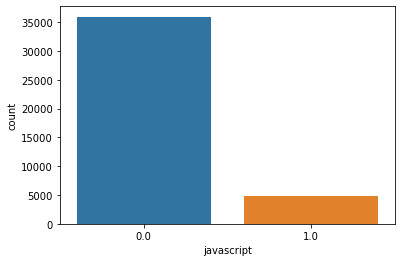

In [15]:
# Value Count, tags le plus fréquent
sns.countplot(df['javascript'])

C:\Users\EliseAndro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='java-8', ylabel='count'>

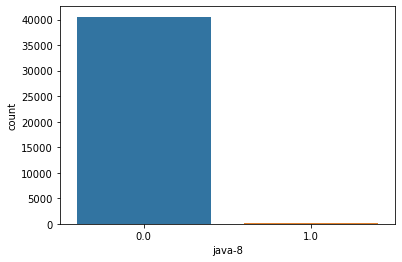

In [16]:
# Value Count, tags le moins fréquent
sns.countplot(df['java-8'])

# Text Preprocessing

In [17]:
tfidf = TfidfVectorizer(analyzer='word',
                        min_df=1,
                        max_df=0.9,
                        ngram_range=(1,3), 
                        max_features=10000, 
                        preprocessor=' '.join)

In [185]:
#enregistrement des du tfidf pour l'api
joblib.dump(tfidf, 'pkl_objects/tfidf.pkl')

['pkl_objects/tfidf.pkl']

In [18]:
# Build Features
Xfeatures = tfidf.fit_transform(df['preprocess_content']).toarray()

In [19]:
print('Xfeatures shape: ',Xfeatures.shape)
Xfeatures

Xfeatures shape:  (40730, 10000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [183]:
y = df[df.columns[3:]]

#enregistrement des noms de tags pour l'api
joblib.dump(list(y.columns), 'pkl_objects/list_tags.pkl')

['pkl_objects/list_tags.pkl']

In [21]:
# Split Data 
X_train,X_test,y_train,y_test = train_test_split(Xfeatures,y,test_size=0.3,random_state=42)

In [22]:
print('training set :', X_train.shape)
print('testing set :', X_test.shape)

training set : (28511, 10000)
testing set : (12219, 10000)


**Fonction pour tester rapidement plusieurs types de modèles**

In [23]:
def build_model(model,mlb_estimator,xtrain,ytrain,xtest,ytest):
    # Create an Instance
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    # Predict
    clf_predictions = clf.predict(xtest)
    # Check For Accuracy
    acc = accuracy_score(ytest,clf_predictions)
    ham = hamming_loss(ytest,clf_predictions)
    result = {"accuracy:":acc, "hamming_score":ham}
    return result

# From multilabel to multiclass problem

## Binary Relevance

Treats each label as a separate single classification problem. 

Label correlation may be lost

In [24]:
BN = build_model(MultinomialNB(), BinaryRelevance ,X_train, y_train, X_test, y_test)

In [25]:
BN

{'accuracy:': 0.11154758981913414, 'hamming_score': 0.014762255503723709}

## Classifier Chains

Forms classifiers chains to preserve label correlation

In [26]:
chain_model = build_model(MultinomialNB(),ClassifierChain,X_train,y_train,X_test,y_test)

In [27]:
chain_model

{'accuracy:': 0.13986414600212782, 'hamming_score': 0.01368606268925444}

## Powerset

Gives a unique class to every possible label combination in the dataset. As data increases the number of classes/labels increases

**MultinomialNB**

In [28]:
labelP_model = build_model(MultinomialNB(), LabelPowerset, X_train, y_train, X_test, y_test)

In [29]:
labelP_model

{'accuracy:': 0.232834110811032, 'hamming_score': 0.01704476634749161}

## OneVsRestClassifier

In [40]:
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC(C=1.5, penalty = 'l1', dual=False)

In [41]:
ovrSVC_model = build_model(svc, OneVsRestClassifier, X_train, y_train, X_test, y_test)

In [44]:
ovrSVC_model

{'accuracy:': 0.3605859726655209, 'hamming_score': 0.009715197643014976}

In [174]:
clfsvc = OneVsRestClassifier(svc)
clfsvc.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.5, dual=False, penalty='l1'))

In [184]:
# save the model
joblib.dump(clfsvc, 'pkl_objects/model_multilabelsvc.pkl')

['pkl_objects/model_multilabelsvc.pkl']

In [178]:
#test
predictiontags(clfsvc, 'message for python css java java pandas numpy')

['numpy', 'python', 'css', 'java']

In [42]:
ovrSGD_model = build_model(sgd,OneVsRestClassifier,X_train,y_train,X_test,y_test)

In [45]:
ovrSGD_model

{'accuracy:': 0.29593256403961044, 'hamming_score': 0.010550781569686554}

In [43]:
ovrLR_model = build_model(lr,OneVsRestClassifier,X_train,y_train,X_test,y_test)

In [46]:
ovrLR_model

{'accuracy:': 0.25435796710041736, 'hamming_score': 0.011320893690154677}

# Multilabel models

## MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(300,) ).fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
# save the model
joblib.dump(clf, 'pkl_objects/model_multilabelMLP.pkl')

In [55]:
# load the model
loaded_model = joblib.load('model_multilabelMLP.pkl')
result = loaded_model.score(X_test, y_test)
print(result)

0.3256403961044275


In [121]:
import gensim
from gensim.utils import simple_preprocess

C:\Users\EliseAndro\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [171]:
def predictiontags(model, message):
    mess = [simple_preprocess(message)]
    tfidf_new = tfidf.transform(mess)
    prediction = model.predict(tfidf_new)
    dfpredict = pd.DataFrame(list(zip(y.columns, prediction[0])), 
                             columns =['Tag', 'Prediction'])
    
    return list(dfpredict.loc[dfpredict['Prediction']==1]['Tag'])

In [172]:
#test
predictiontags(loaded_model, 'message for python test pandas numpy')

['numpy', 'python']

## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

clfrf = RandomForestClassifier(max_depth=3, random_state=0)
clfrf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [51]:
clfrf.score(X_test, y_test)

0.0